In [1251]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import sudukoSolver

In [1252]:
heightImg = 450
widthImg = 450
img=cv2.imread ("images/phone2.png")
img = cv2.resize(img, (widthImg, heightImg))


In [1253]:
def showImage(img, name='my-image'):
    plt.imshow(img,cmap='gray')
    plt.title(name)
    plt.axis('off')
    plt.show()



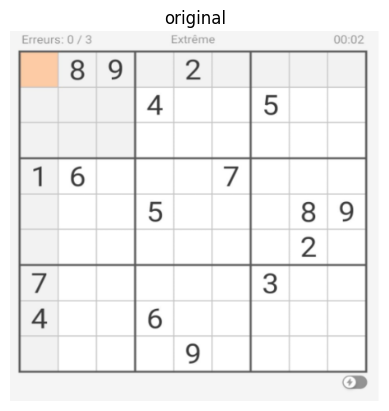

In [1254]:
showImage(img, 'original')

#### 1 - Preprocessing Image

In [1255]:


def preProcess(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 0, cv2.BORDER_DEFAULT)  # ADD GAUSSIAN BLUR
    imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)  # APPLY ADAPTIVE THRESHOLD
    return imgThreshold

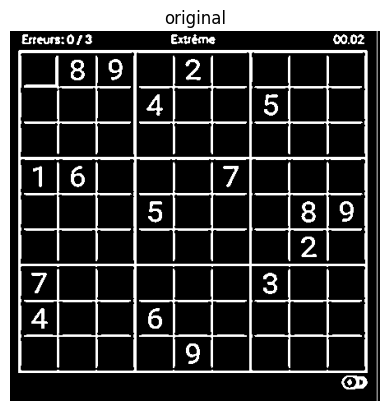

In [1256]:
imgThreshold = preProcess(img)
showImage(imgThreshold, 'original')


#### 2. FIND ALL COUNTOURS

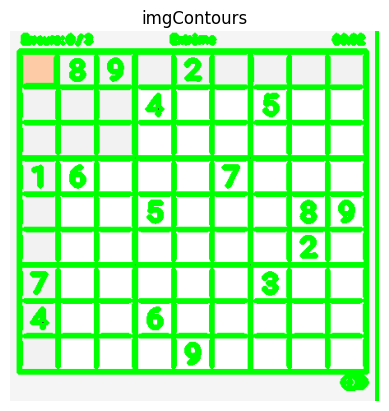

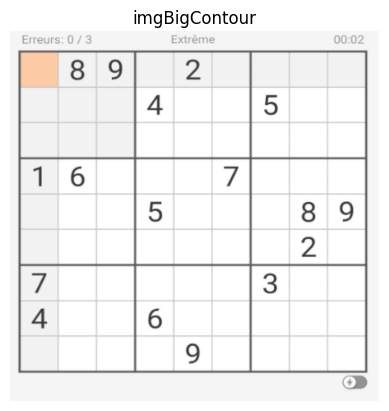

In [1257]:
imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES

## #cv.RETR_LIST, cv.RETR_TREE, cv.RETR_CCOMP, cv.RETR_EXTERNAL
 ## CHAIN_APPROX_NONE CHAIN_APPROX_SIMPLE CHAIN_APPROX_TC89_L1 CHAIN_APPROX_TC89_KCOS 
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3) # DRAW ALL DETECTED CONTOURS
showImage(imgContours, 'imgContours')
showImage(imgBigContour, 'imgBigContour')


#### 3. FIND THE BIGGEST COUNTOUR AND USE IT AS SUDOKU


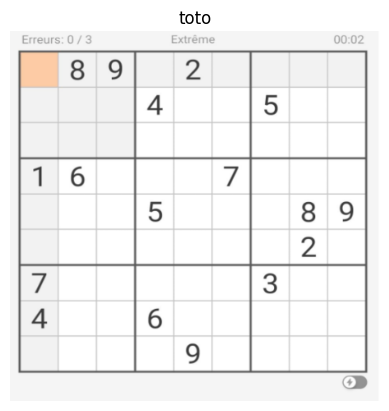

In [1258]:
def testContours(contours,image):
    filtered_image = image.copy()
    for contour in contours:
        # Calculer l'aire du contour
        area = cv2.contourArea(contour)
        
        # Approximer le contour pour obtenir le nombre de côtés
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # Filtrer les contours en fonction de l'aire et du nombre de côtés
        if area > 70000 and len(approx) > 6:
        #if area > 6000 and len(approx) == 4:
            # Dessiner le contour sur l'image filtrée
            cv2.drawContours(filtered_image, [contour], -1, (0, 255, 0), 5)
    return filtered_image
            
toto = testContours(contours,imgBigContour)
showImage(toto, 'toto')


In [1259]:
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area



In [1260]:
#### 3 - Reorder points for Warp Perspective
def reorder(myPoints):
   
    myPoints = myPoints.reshape((4, 2))

    print(myPoints.shape)
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    print('*****')
    print(myPointsNew)
    
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew


(4, 2)
*****
[[[0 0]]

 [[0 0]]

 [[0 0]]

 [[0 0]]]


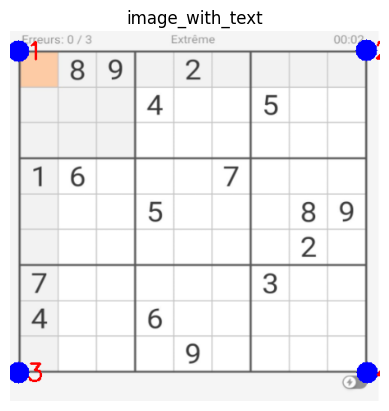

In [1261]:
biggest, maxArea = biggestContour(contours) # FIND THE BIGGEST CONTOUR
if biggest.size != 0:
    #biggest = reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0, 0, 255), 25) # DRAW THE BIGGEST CONTOUR


def write_text_next_to_points(image, points, text_offset=10, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, color=(255, 0, 0), thickness=2):
    # Copier l'image pour éviter de modifier l'original
    image_with_text = image.copy()
    points = reorder(points)
    # Parcourir les points et écrire un texte à côté de chaque point
    for i, point in enumerate(points, start=1):
        # Coordonnées du point
        x, y = point[0]
        # Texte à écrire à côté du point
        text = f"{i}"
        # Dessiner le texte à côté du point
        cv2.putText(image_with_text, text, (x + text_offset, y + text_offset), font, font_scale, color, thickness)
    return image_with_text
    
image_with_text = write_text_next_to_points(imgBigContour, biggest)
showImage(image_with_text, 'image_with_text')



In [1262]:
biggest, maxArea = biggestContour(contours) # FIND THE BIGGEST CONTOUR
print('maxArea',maxArea)
print(biggest)

if biggest.size != 0:
    biggest = reorder(biggest)
    print('_________')
    #print(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (255, 0, 255), 25) # DRAW THE BIGGEST CONTOUR
    pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
    pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
    matrix = cv2.getPerspectiveTransform(pts1, pts2) # GER
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    imgBlank = np.zeros((heightImg, widthImg, 3), np.uint8) 
    imgWarpColored = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)


maxArea 166207.0
[[[ 10  24]]

 [[ 10 415]]

 [[434 415]]

 [[433  23]]]
(4, 2)
*****
[[[0 0]]

 [[0 0]]

 [[0 0]]

 [[0 0]]]
_________


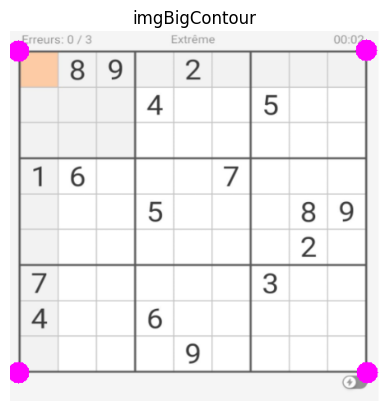

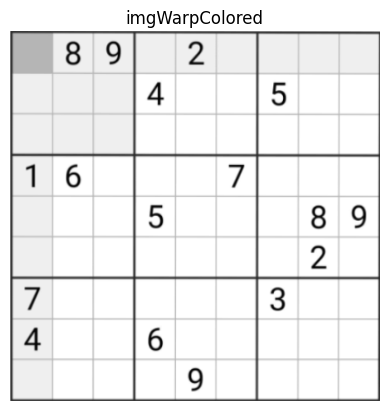

In [1263]:
showImage(imgBigContour, 'imgBigContour')
showImage(imgWarpColored, 'imgWarpColored')
#cv2.imwrite("nouvelle_image.jpg", imgWarpColored)



#### 4. SPLIT THE IMAGE AND FIND EACH DIGIT AVAILABLE

In [1264]:
#### 4 - TO SPLIT THE IMAGE INTO 81 DIFFRENT IMAGES
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [1265]:
  boxes = splitBoxes(imgWarpColored)

In [1266]:
#### 4 - GET PREDECTIONS ON ALL IMAGES
def getPredectionOneImage(image, model):
    img = np.asarray(image)
    border=4
    img = img[border:img.shape[0] - border, border:img.shape[1] -border]
    img = cv2.resize(img,(32,32))
    img = img/255
    imageWithoutBorder = img.copy() 
    img = img.reshape(1,32,32,1)
    #### PREDICT
    predictions = model.predict(img)
    classIndex = np.argmax(predictions, axis=1)
    probVal= np.amax(predictions)
    minAccept=0.50
    if probVal> minAccept:
        cv2.putText(imageWithoutBorder,str(classIndex) + "   "+str(probVal), (50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),1)
    #showImage(imageWithoutBorder)
    print(classIndex,probVal)
    return classIndex[0] if probVal > minAccept else 0




In [1267]:
model = load_model('model_trained.keras')

In [1268]:
getPredectionOneImage(boxes[16],model)

1/1 [==============================] - 0s 39ms/step
[1] 0.37047496


0

In [1269]:
def getAllPreditions(boxes,model):
    result=[]
    for image in boxes:
        result.append(getPredectionOneImage(image,model))
    return result

In [1270]:
numbers =getAllPreditions(boxes,model)

1/1 [==============================] - 0s 8ms/step
[1] 0.37047496
1/1 [==============================] - 0s 9ms/step
[8] 0.99904734
1/1 [==============================] - 0s 8ms/step
[9] 0.9975993
1/1 [==============================] - 0s 8ms/step
[1] 0.37047496
1/1 [==============================] - 0s 7ms/step
[2] 0.99997056
1/1 [==============================] - 0s 7ms/step
[1] 0.37047496
1/1 [==============================] - 0s 7ms/step
[1] 0.37047496
1/1 [==============================] - 0s 7ms/step
[1] 0.37047496
1/1 [==============================] - 0s 7ms/step
[1] 0.37047496
1/1 [==============================] - 0s 8ms/step
[1] 0.37047496
1/1 [==============================] - 0s 7ms/step
[1] 0.37047496
1/1 [==============================] - 0s 7ms/step
[1] 0.37047496
1/1 [==============================] - 0s 8ms/step
[4] 1.0
1/1 [==============================] - 0s 8ms/step
[1] 0.37047496
1/1 [==============================] - 0s 7ms/step
[1] 0.37047496
1/1 [=============

In [1271]:
#### 6 -  TO DISPLAY THE SOLUTION ON THE IMAGE
def displayNumbers(img,numbers,color = (0,0,0)):

    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            currentBox=(y*9)+x
            if numbers[currentBox] != 0 :
                 cv2.putText(img, str(numbers[currentBox]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img

In [1272]:

def imageBlank(heightImg=450, widthImg=450):
    return np.zeros((heightImg, widthImg, 3), np.uint8)



In [1273]:
def addGridImage(image):
    img= image.copy()
    secW = int(img.shape[1])
    secH = int(img.shape[0])
    for i in range(0, 10):
        thickness = 4 if i % 3 == 0 else 2  # Épaisseur 4 pour les lignes 3x3, sinon 2
        
        # Lignes verticales
        cv2.line(img, (i * secW // 9, 0), (i * secW // 9, secH), (255, 0, 0), thickness)
        
        # Lignes horizontales
        cv2.line(img, (0, i * secH // 9), (secW, i * secH // 9), (255, 0, 0), thickness)
    return img

In [1274]:
# Afficher les deux images
def displayTwoImage(image1,image2):
    plt.subplot(1, 2, 1)  # Créer une sous-fenêtre à gauche
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))  # Convertir de BGR à RGB pour matplotlib
    plt.title("image 1")
    plt.axis('off')
    plt.subplot(1, 2, 2)  # Créer une sous-fenêtre à droite
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))  # Convertir de BGR à RGB pour matplotlib
    plt.title("image 2")
    plt.axis('off')
    plt.show()

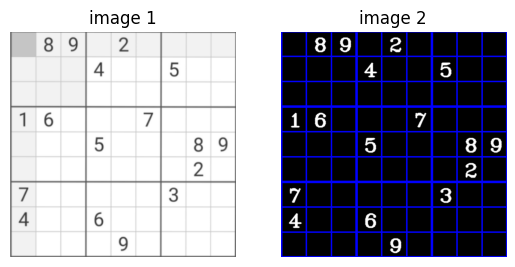

In [1275]:

image_numbers = displayNumbers(imageBlank(),numbers, (255,255,255))
imageNumberWithGrid=addGridImage(image_numbers)
displayTwoImage(imgWarpColored,imageNumberWithGrid)


In [1276]:
# pour qu'ensuite on remplis sur l'image original que les chiffres manquants, ceux qui ont un 1 ici

numbers=np.asarray(numbers)
posArray = np.where(numbers>0, 0,1)

In [1277]:
board = np.array_split(numbers,9)
print(board)
try:
    sudukoSolver.solve(board)
except:
    pass


[array([0, 8, 9, 0, 2, 0, 0, 0, 0]), array([0, 0, 0, 4, 0, 0, 5, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 6, 0, 0, 0, 7, 0, 0, 0]), array([0, 0, 0, 5, 0, 0, 0, 8, 9]), array([0, 0, 0, 0, 0, 0, 0, 2, 0]), array([7, 0, 0, 0, 0, 0, 3, 0, 0]), array([4, 0, 0, 6, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 9, 0, 0, 0, 0])]


In [1278]:
print(board)
flatList = [item for sublist in board for item in sublist]

[array([5, 8, 9, 7, 2, 6, 1, 3, 4]), array([2, 1, 7, 4, 3, 9, 5, 6, 8]), array([6, 4, 3, 8, 5, 1, 9, 7, 2]), array([1, 6, 2, 9, 8, 7, 4, 5, 3]), array([3, 7, 4, 5, 1, 2, 6, 8, 9]), array([9, 5, 8, 3, 6, 4, 7, 2, 1]), array([7, 9, 5, 2, 4, 8, 3, 1, 6]), array([4, 2, 1, 6, 7, 3, 8, 9, 5]), array([8, 3, 6, 1, 9, 5, 2, 4, 7])]


In [1279]:
solvedNumbers =flatList*posArray

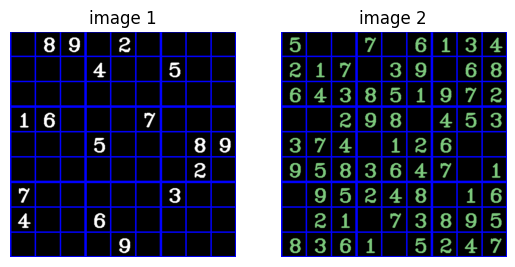

In [1280]:
imgSolvedDigits=displayNumbers(imageBlank(),solvedNumbers, (124,200,124))
imageSovedWithGrid=addGridImage(imgSolvedDigits)
displayTwoImage(imageNumberWithGrid,imageSovedWithGrid)

#### create solution on origninal Image

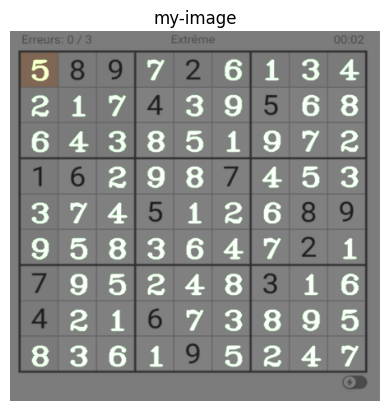

In [1282]:
pts2 = np.float32(biggest) # PREPARE POINTS FOR WARP
pts1 =  np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(pts1, pts2)  # GER
imgInvWarpColored = img.copy()
imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix, (widthImg, heightImg))
inv_perspective = cv2.addWeighted(imgInvWarpColored, 1, img, 0.5, 1)


showImage(inv_perspective)
